# Optimization vs. expressibility of the circuit

## Overview

In this tutorial, we will show the relationship between circuit parameter optimization and circuit expressibility. Utilizing the variational quantum eigensolver (VQE) algorithm, we can get the ground state energy of the quantum many-body system. Although the random parameterized circuit will have larger expressibility with more layers, since the entanglement entropy of the ground state satisfies “area law”, the accurate ground state energy can not be obtained because of the entanglement made by the random circuit.

The model considered here reads:
$$
H = \sum_{i=1}^{n}\sigma_{i}^{z}\sigma_{i+1}^{z}+\sum_{i=1}^{n}\sigma_{i}^{x},
$$
where $\sigma_{i}^{x,z}$ are Pauli matrices of the $i$-th qubit. The expressibility is measured through the Renyi entanglement entropy:
$$
R_{A}^{2} = - \rm{log} (\rm{tr}_{A}\rho_{A}^{2}),
$$
where $\rho_{A}$ is obtained through partially tracing out subsystem $A$.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import tensorcircuit as tc
import quspin

tc.set_backend("tensorflow")
tc.set_dtype("complex128")
dtype = np.complex128

### Parameters

In [2]:
N = 4  # The number of qubits
NA = [i for i in range(int(N / 2))]  # Subsystem A
L = 2  # The number of circuit layers
num_trial = 2  # The number of random circuit instances

### Exact Diagonalization

In [3]:
basis = quspin.basis.spin_basis_1d(N)
J_zz = [[1.0, i, (i + 1) % N] for i in range(N)]
J_x = [[1.0, i] for i in range(N)]
H_TFIM = quspin.operators.hamiltonian(
    [["zz", J_zz], ["x", J_x]], [], basis=basis, check_symm=False, dtype=np.float64
)
E, V = H_TFIM.eigh()
E0 = E[0]
print("The ground state energy: ", E0)

Hermiticity check passed!
The ground state energy:  -5.226251859505491


### The Density Matrix of the Output State

The circuit architecture is shown below, each block includes two Pauli rotation gates along the y-axis ($R_{y}$) followed by the $CZ$ gate.

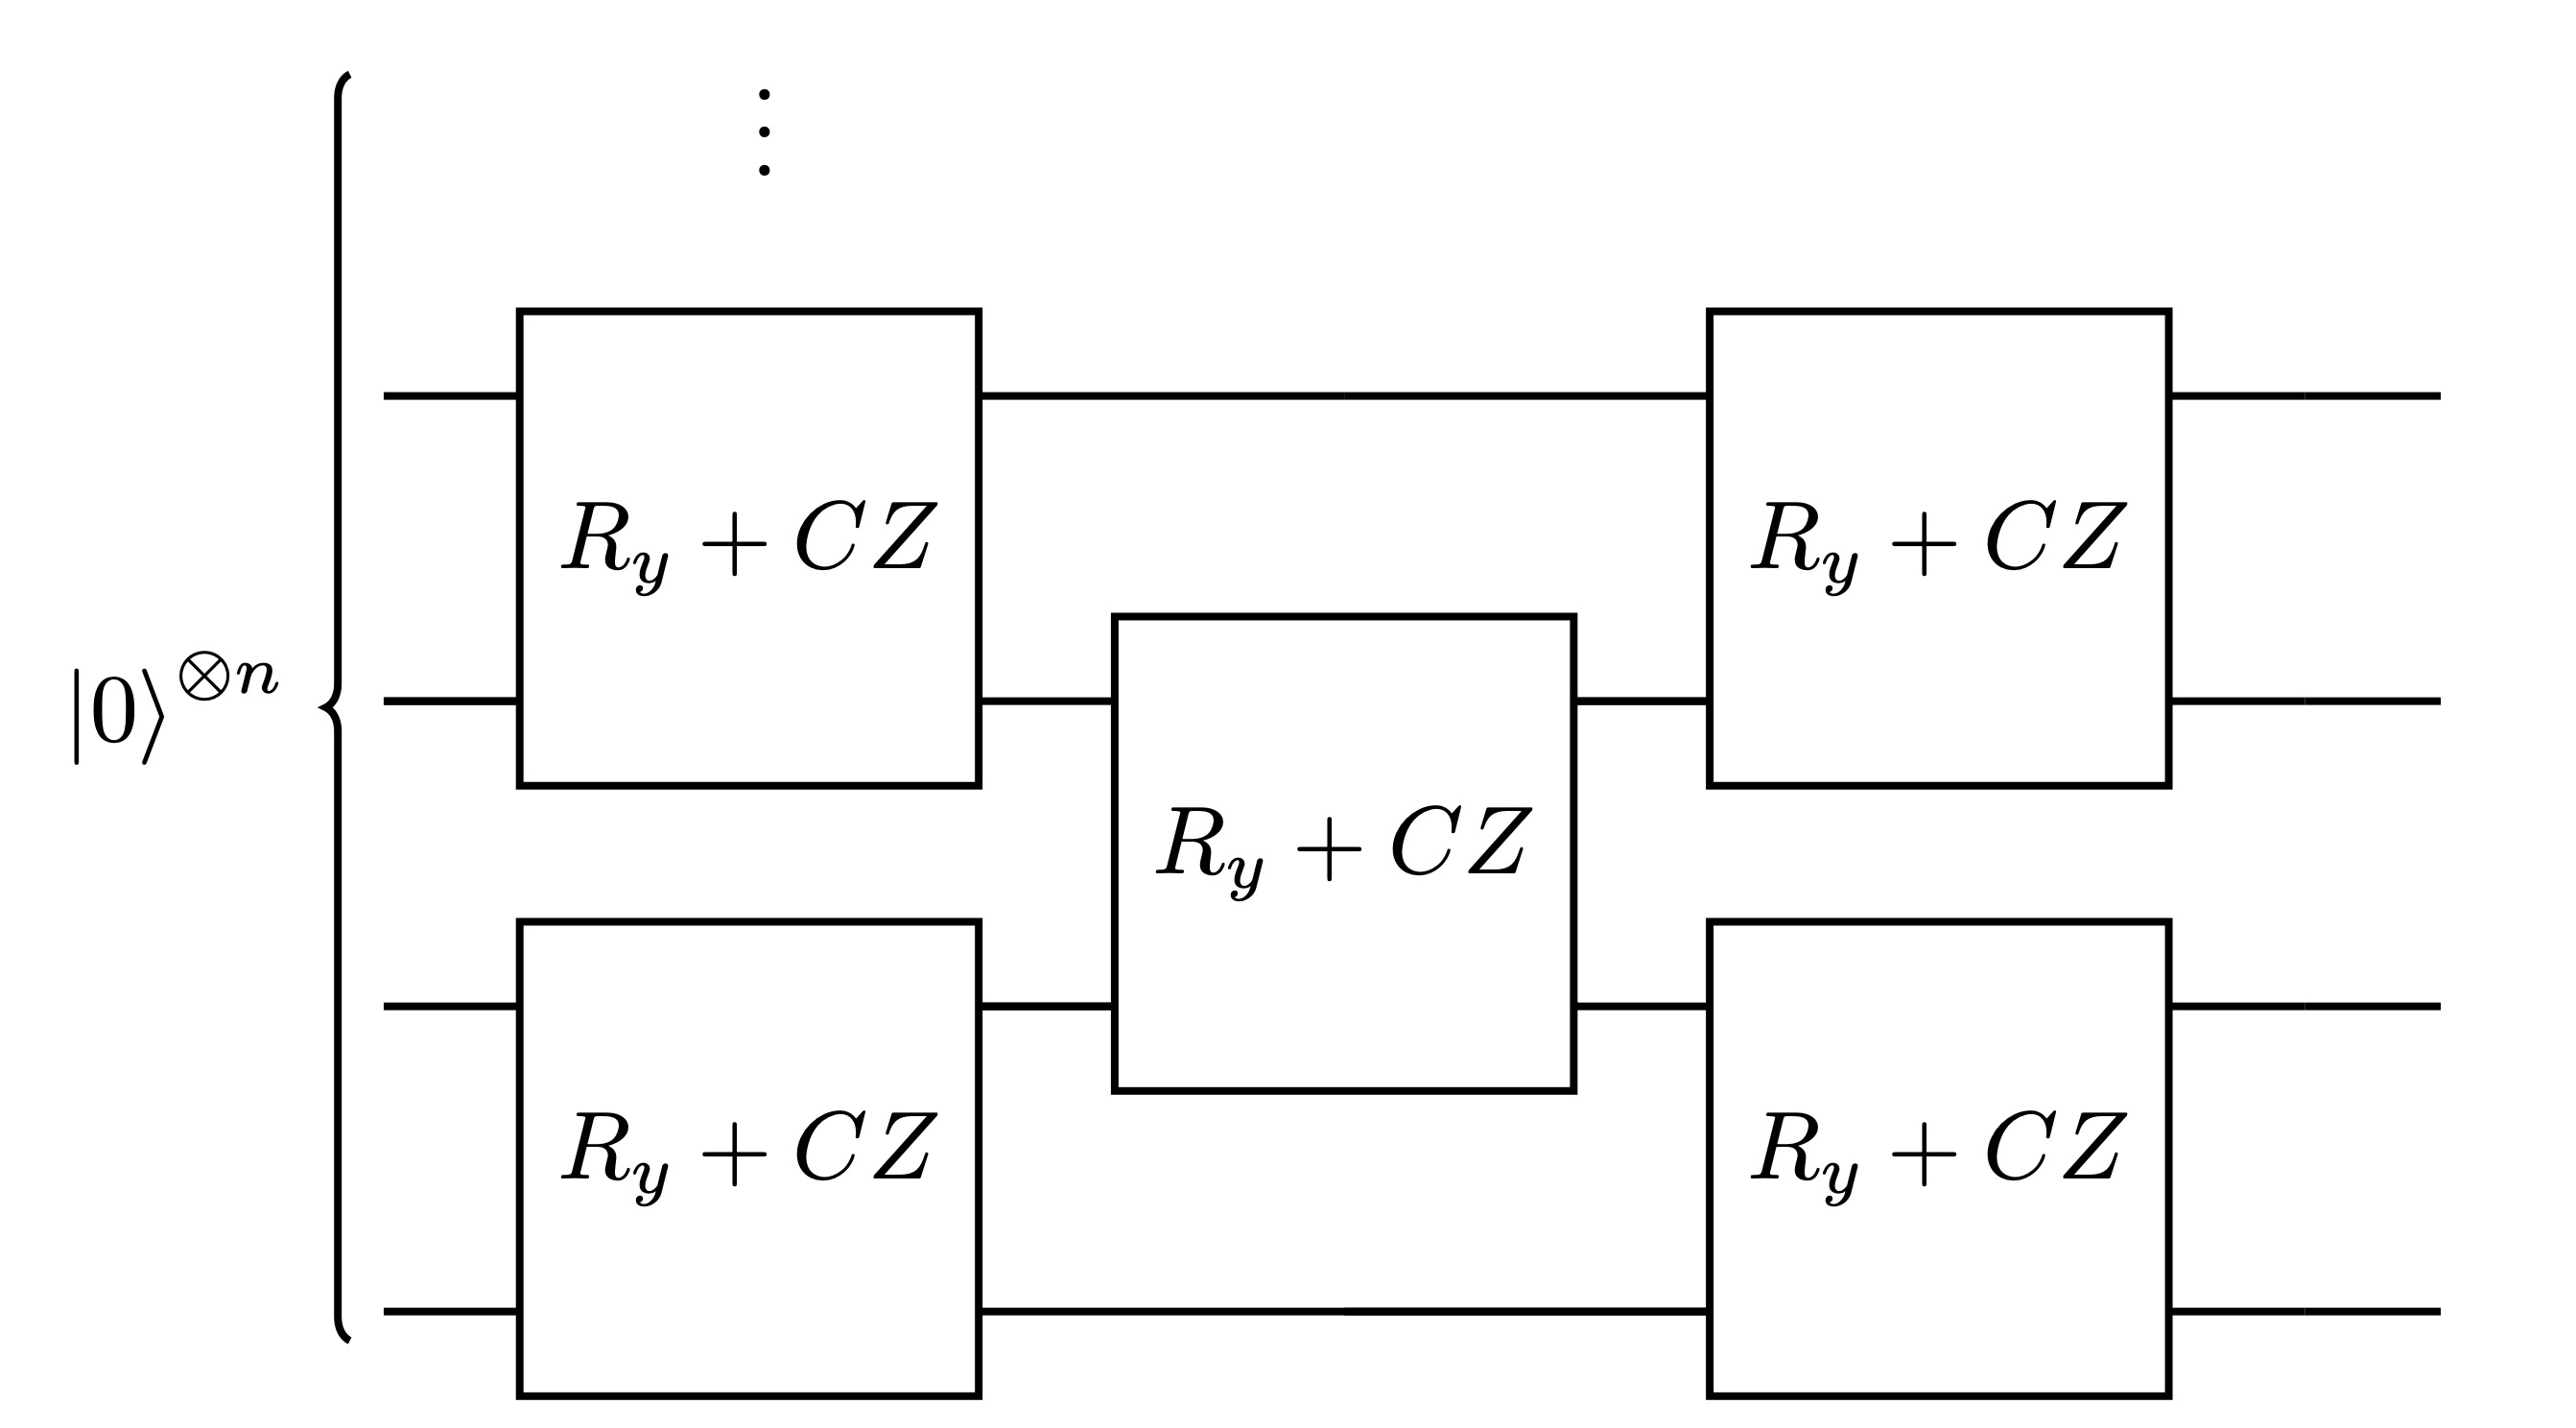

In [4]:
@tf.function
def get_state(v):
    layers = len(v)
    c = tc.Circuit(N)
    # Ry+Cz
    for layer in range(layers):
        if layer % 2 == 0:
            for i in range(0, N, 2):
                c.ry(i, theta=v[layer, i])
                c.ry(i + 1, theta=v[layer, i + 1])
                c.cz(i, i + 1)
        else:
            for i in range(1, N, 2):
                c.ry(i, theta=v[layer, i])
                c.ry((i + 1) % N, theta=v[layer, (i + 1) % N])
                c.cz(i, (i + 1) % N)
    ψ = c.wavefunction()  # the output state
    return ψ

### Hamiltonian

In [5]:
def get_hamiltonian():
    h = []
    w = []
    ###ZZ
    for i in range(N):
        h.append([])
        w.append(1.0)  # weight
        for j in range(N):
            if j == (i + 1) % N or j == i:
                h[i].append(3)
            else:
                h[i].append(0)
    ###potential
    for i in range(N):
        h.append([])
        w.append(1.0)
        for j in range(N):
            if j == i:
                h[i + N].append(1)
            else:
                h[i + N].append(0)

    hamiltonian = tc.quantum.PauliStringSum2Dense(
        tf.constant(h, dtype=tf.complex128), tf.constant(w, dtype=tf.complex128)
    )
    return hamiltonian

### Loss Function

$$
C(\theta) = \langle H \rangle.
$$

In [6]:
@tf.function
def energy_loss(v, hamiltonian):
    ψ = get_state(v)
    ψ = tf.reshape(ψ, [2 ** N, 1])
    loss = tf.transpose(ψ, conjugate=True) @ hamiltonian @ ψ
    loss = tc.backend.real(loss)
    return loss

### Rényi Entanglement Entropy

$$
R_{A}^{2} = - \rm{log} (\rm{tr}_{A}\rho_{A}^{2}),
$$
where $\rho_{A}$ is obtained through partially tracing out subsystem $A$.

In [7]:
@tf.function
def entropy(v):
    ψ = get_state(v)
    ρ_reduced = tc.quantum.reduced_density_matrix(
        ψ, NA
    )  # reduced density matrix obtained through partially tracing out subsystem A
    S = tc.quantum.renyi_entropy(ρ_reduced)  # renyi entanglement entropy
    return S

### Main Optimization Loop

In [8]:
def opt_main(v):
    opt = tc.backend.optimizer(tf.keras.optimizers.Adam(1e-2))

    hamiltonian = get_hamiltonian()

    loss_and_grad = tc.backend.jit(tc.backend.value_and_grad(energy_loss, argnums=0))
    loss_and_grad_vag = tc.backend.jit(
        tc.backend.vvag(loss_and_grad, argnums=0, vectorized_argnums=0)
    )  # use vvag to get losses and gradients of different random circuit instances
    entropy_vag = tc.backend.jit(
        tc.backend.vmap(entropy, vectorized_argnums=0)
    )  # use vmap to get renyi entanglement entropy of different random circuit instances

    maxiter = 100
    for i in range(maxiter):
        loss, gr = loss_and_grad_vag(v, hamiltonian)

        if i == 0:
            E_initial_avg = tf.reduce_mean(loss[0])  # energy of the initial state
            S_initial = entropy_vag(v)
            S_initial_avg = tf.reduce_mean(
                S_initial[0]
            )  # renyi entanglement entropy of the initial state
        elif i == maxiter - 1:
            E_final_avg = tf.reduce_mean(loss[0])  # energy of the final state
            S_final = entropy_vag(v)
            S_final_avg = tf.reduce_mean(
                S_final[0]
            )  # renyi entanglement entropy of the final state

        v = opt.update(gr, v)

    return (
        E_initial_avg.numpy(),
        E_final_avg.numpy(),
        S_initial_avg.numpy(),
        S_final_avg.numpy(),
    )

In [9]:
v = tf.random.uniform([num_trial, L, N], minval=0.0, maxval=2 * np.pi, dtype=tf.float64)
E_initial, E_final, S_initial, S_final = opt_main(v)

2022-02-18 15:28:57.668768: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-18 15:28:58.399077: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7fe206d450b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-18 15:28:58.399104: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2022-02-18 15:28:58.581897: I tensorflow/compiler/jit/xla_compilation_cache.cc:351] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [10]:
print("Number of layers = ", L, ";")
print(
    "ΔE (initial) = ",
    E_initial - E0,
    ";",
    "ΔE (final) = ",
    E_final - E0,
)
print(
    "S (initial) = ",
    S_initial,
    ";",
    "S (final) = ",
    S_final,
)

Number of layers =  2 ;
ΔE (initial) =  6.496137029102603 ; ΔE (final) =  3.666036635713118
S (initial) =  0.561303369826885 ; S (final) =  0.07905923157886821


### Results

The energy and Rényi entropy for a system of $n = 12$ qubits and a different number of layers $L$ averaged over 13 random circuit instances. Per each independent random instance, we will allow enough time for convergence towards the ground state by waiting for 1000 steps of the parameter update. We can see that Rényi entanglement entropy at random parameters saturating around its maximum possible value, has an adverse effect in reaching the ground state of the VQE Hamiltonian.

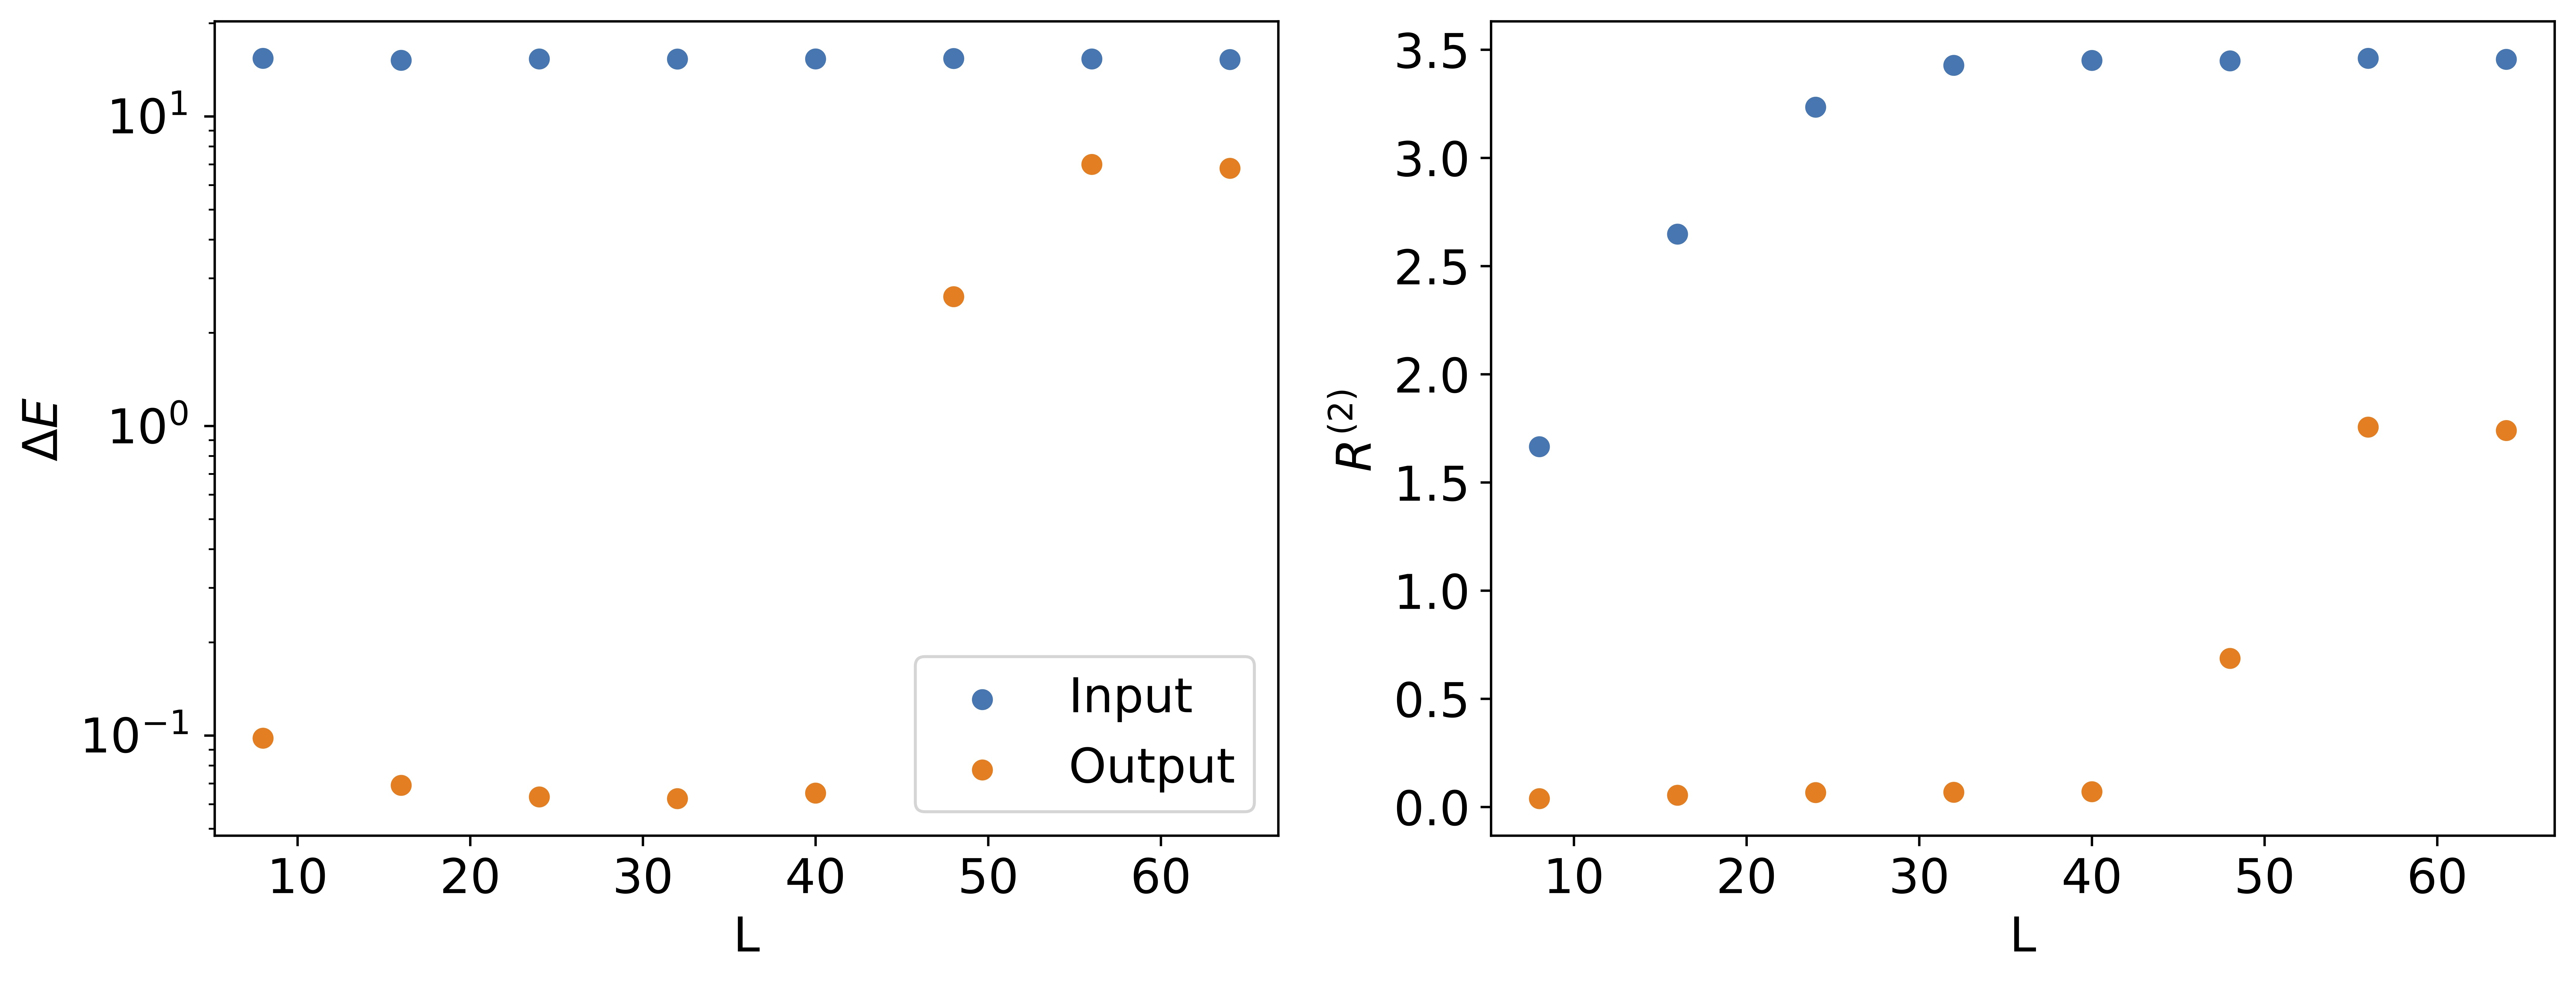

### Reference

Reference paper: https://arxiv.org/pdf/2201.01452.pdf.